<a href="https://colab.research.google.com/github/majensen/sp-project/blob/main/08_nucleus_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nucleus Instance Segmentation

Click to open in: \[[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/08-nucleus-instance-segmentation.ipynb)\]\[[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/develop/examples/08-nucleus-instance-segmentation.ipynb)\]



## About this notebook

This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.



## About this demo

Each WSI can contain up to million nuclei of various types, which can be further analysed systematically and used for predicting clinical outcomes. In order to use nuclear features for downstream analysis within computational pathology, nucleus segmentation and classification must be carried out as an initial step. However, this remains a challenge because nuclei display a high level of heterogeneity and there is significant inter- and intra-instance variability in the shape, size and chromatin pattern between and within different cell types, disease types or even from one region to another within a single tissue sample. Tumour nuclei, in particular, tend to be present in clusters, which gives rise to many overlapping instances, providing a further challenge for automated segmentation, due to the difficulty of separating neighbouring instances.

> ![image](https://tiatoolbox.dcs.warwick.ac.uk/notebook/hovernet_samples.PNG)
> Image courtesy of Graham, Simon, et al. "Hover-net: Simultaneous segmentation and classification of nuclei in multi-tissue histology images." Medical Image Analysis 58 (2019): 101563.

In this example, we will demonstrate how you can use the TIAToolbox implementation of [HoVer-Net](https://arxiv.org/pdf/1812.06499.pdf) to tackle these challenges and solve the problem of nuclei instance segmentation and classification within histology images. HoVer-Net is a deep learning approach based on horizontal and vertical distances (and hence the name HoVer-Net) of nuclear pixels to the centre of mass of the corresponding nucleus. These distances are used to separate clustered nuclei. For each segmented instance, the nucleus type is subsequently determined via a dedicated up-sampling branch.

In this example notebook, we are not going to explain how HoVer-Net works (for more information we refer you to the [HoVer-Net paper](https://www.sciencedirect.com/science/article/pii/S1361841519301045)), but we will show how easily you can use the sophisticated HoVer-Net model, which is incorporated in TIATtoolbox, to do automatic segmentation and classification of nucleus instances. Mostly, we will be working with the [NucleusInstanceSegmentor](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/models/engine/nucleus_instance_segmentor.py#L256) which by default uses one of the pretrained [HoVerNet](link_to_hovernet_dcoumentation) models. We will also cover the [visualisation tool](https://tia-toolbox.readthedocs.io/en/develop/usage.html?#module-tiatoolbox.utils.visualization) embedded in TIAToolbox for overlaying the instance segmentation results on the input image.



## Setting up the environment

### TIAToolbox and dependencies installation

You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [ ]:
%%bash
apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
pip install numpy==1.24.3  # Install a specific numpy version
pip install torchvision==0.16.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html # Install torchvision with a specific version
pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
echo "Installation is done."


Installation is done.


  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-aq45r0zz
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
jupyter-kernel-gateway 2.5.2 requires jupyter-client<8.0,>=5.2.0, but you have jupyter-client 8.6.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
notebook 6.5.7 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.3 which is incompatible.


> **IMPORTANT**: If you are using Colab and you run the cell above for the first time, please note that you need to restart the runtime before proceeding through (menu) *"Runtime→Restart runtime"* . This is needed to load the latest versions of prerequisite packages installed with TIAToolbox. Doing so, you should be able to run all the remaining cells altogether (*"Runtime→Run after"* from the next cell) or one by one.



### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.



In [ ]:
"""Import modules required to run the Jupyter notebook."""

# Clear logger to use tiatoolbox.logger
import logging
import warnings

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

import cv2
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from tiatoolbox import logger
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor
from tiatoolbox.utils.misc import download_data, imread

# We need this function to visualize the nuclear predictions
from tiatoolbox.utils.visualization import (
    overlay_prediction_contours,
)
from tiatoolbox.wsicore.wsireader import WSIReader

warnings.filterwarnings("ignore")
mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode
plt.rcParams.update({"font.size": 5})

|2025-07-30|17:43:32.781| [INFO] NumExpr defaulting to 2 threads.


### GPU or CPU runtime

Processes in this notebook can be accelerated by using a GPU. Therefore, whether you are running this notebook on your system or Colab, you need to check and specify appropriate [device](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) e.g., "cuda" or "cpu" whether you are using GPU or CPU. In Colab, you need to make sure that the runtime type is set to GPU in the *"Runtime→Change runtime type→Hardware accelerator"*. If you are *not* using GPU, consider changing the `device` flag to `cpu` value, otherwise, some errors will be raised when running the following cells.



In [ ]:
device = "cuda"  # Choose appropriate device

### Removing leftovers from previous runs

The cell below removes some redundant directories if they exist—a previous run may have created them. This cell can be skipped if you are running this notebook for the first time.



In [ ]:
%%bash
rm -rf tmp
echo "deleting tmp directory"
rm -r sample_tile_results
echo "deleting 'sample_tile_results' directory"
rm -r sample_wsi_results
echo "deleting 'sample_wsi_results' directory"

deleting tmp directory
deleting 'sample_tile_results' directory
deleting 'sample_wsi_results' directory


rm: cannot remove 'sample_tile_results': No such file or directory
rm: cannot remove 'sample_wsi_results': No such file or directory


### Downloading the required files

We download, over the internet, image files used for the purpose of this notebook. In particular, we download a histology tile and a whole slide image of cancerous breast tissue samples to show how the nucleus instance segmentation model works.

> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files that the code in this notebook can access. The data will appear here when it is downloaded.
>
> 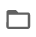



In [ ]:
# These file name are used for the experimenets
img_file_name = "sample_tile.png"
wsi_file_name = "sample_wsi.svs"


logger.info("Download has started. Please wait...")

# Downloading sample image tile
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/breast_tissue_crop.png",
    img_file_name,
)

# Downloading sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/wsi4_12k_12k.svs",
    wsi_file_name,
)

logger.info("Download is complete.")

|2025-07-30|17:44:54.327| [INFO] Download has started. Please wait...
|2025-07-30|17:44:58.329| [INFO] Download is complete.


## Nucleus instance segmentation and classification using TIAToolbox's pretrained HoVer-Net model

In this section, we will investigate the use of the HoVer-Net model that has been already trained on the PanNuke dataset and incorporated in the TIAToolbox.
The model we demonstrate can segment out nucleus instances in the image and assign one of the following 6 classes to them:

- Background
- Neoplastic Epithelial
- Non-Neoplastic Epithelial
- Inflammatory
- Connective
- Dead

### Inference on tiles

Similarly to the semantic segmentation functionality of the TIAToolbox, the instance segmentation module works both on image tiles and structured WSIs. First, we need to create an instance of the `NucleusInstanceSegmentor` class which controls the whole process of the nucleus instance segmentation task and then use it to do prediction on the input image(s):



In [ ]:
# Tile prediction
inst_segmentor = NucleusInstanceSegmentor(
    pretrained_model="hovernet_fast-pannuke",
    num_loader_workers=2,
    num_postproc_workers=2,
    batch_size=4,
)

tile_output = inst_segmentor.predict(
    [img_file_name],
    save_dir="sample_tile_results/",
    mode="tile",
    device=device,
    crash_on_exception=True,
)

|2025-07-30|17:45:15.851| [WARNING] GPU is not compatible with torch.compile. Compatible GPUs include NVIDIA V100, A100, and H100. Speedup numbers may be lower than expected.
|2025-07-30|17:45:15.853| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2025-07-30|17:45:16.242| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2025-07-30|17:45:16.372| [WARNING] Raw data is None.
|2025-07-30|17:45:16.373| [WARNING] Unknown scale (no objective_power or mpp)
Process Batch:   0%|                                     | 0/13 [00:00<?, ?it/s]|2025-07-30|17:45:16.534| [WARNING] Raw data is None.
|2025-07-30|17:45:16.554| [WARNING] Raw data is None.
Process Batch: 100%|##############################| 3/3 [00:01<00:00,  2.68it/s]


|2025-07-30|17:45:33.567| [INFO] Finish: 0
|2025-07-30|17:45:33.568| [INFO] --Input: sample_tile.png
|2025-07-30|17:45:33.569| [INFO] --Output: /content/sample_tile_results/0


There we go! With only two lines of code, thousands of images can be processed automatically.
There are various parameters associated with `NucleusInstanceSegmentor`. We explain these as we meet them while proceeding through the notebook. Here we explain only the ones mentioned above:

- `pretrained_model`: specifies the name of the pretrained model included in the TIAToolbox (case sensitive). We are expanding our library of models pretrained on various (instance) segmentation tasks. You can find a complete list of currently available pretrained models [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=architecture#module-tiatoolbox.models.architecture). In this example, we use the `"hovernet_fast-pannuke"` pretrained model, which is HoVer-Net model trained on the [PanNuke dataset](https://arxiv.org/abs/2003.10778). Another option for HoVer-Net is `hovernet_original-kumar` which is the original version of the HoVer-Net model trained on a dataset by [Kumar et al.](https://www.dropbox.com/s/j3154xgkkpkri9w/IEEE_TMI_NuceliSegmentation.pdf?dl=0)

- `num_loader_workers`: as the name suggests, this parameter controls the number of CPU cores (workers) that are responsible for the "loading of network input" process, which consists of patch extraction, preprocessing, etc.

- `num_postproc_workers`: as the name suggests, this parameter controls the number of CPU cores (workers) that are responsible for the "model related post-processing" tasks, which consist of horizontal and vertical maps gradient calculations, instance marker generation, and marker-controlled watershed method to generate the final instance map (for more information, please refer to the [HoVer-Net paper](https://www.sciencedirect.com/science/article/pii/S1361841519301045)).

- `batch_size`: controls the batch size, or the number of input instances to the network in each iteration. If you use a GPU, be careful not to set the `batch_size` larger than the GPU memory limit would allow.

After the `inst_segmentor` has been instantiated as the instance segmentation engine with our desired pretrained model, one can call the `predict` method to do inference on a list of input images (or WSIs). The `predict` function automatically processes all the images on the input list and saves the results on the disk. The process usually comprises patch extraction (because the whole tile or WSI won't fit into limited GPU memory), preprocessing, model inference, post-processing and prediction assembly. Here are some important parameters required by the `predict` method properly:

- `imgs`: List of inputs to be processed. Note that items in the list should be paths to the inputs.

- `save_dir`: Path to the main folder in which prediction results for each input are stored separately.

- `mode`: the mode of inference which can be set to either `'tile'` or `'wsi'` for plain histology images or structured whole slides images, respectively.

- `device`: specify appropriate [device](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) e.g., "cuda", "cuda:0", "mps", "cpu" etc.

- `crash_on_exception`: If set to `True`, the running loop will crash if there is an error during processing a WSI. Otherwise, the loop will move on to the next image (wsi) for processing. We suggest that you first make sure that the prediction is working as expected by testing it on a couple of inputs and then set this flag to `False` to process large cohorts of inputs.

In `tile_output`, the `prediction` method returns a list of paths to its inputs and to the processed outputs saved on disk. This can be used later during processing and visualisation.
Similarly to prediction for the `SemanticSegmentor` class, the `predict` method here can also accepts some arguments to set the input/output configurations of the model. These arguments are `ioconfig` (which accecpts a instance from `tiatoolbox.models.engine.semantic_segmentor.IOSegmentorConfig` class) or `resolution`, `patch_input_shape`, `patch_output_shape`, and `stride_shape` based on which an appropriate `IOSegmentorConfig` will be generated.
When you are using TIAToolbox pretrained models, we recommend using the default values of input/output shape.

Now that the prediction has finished, let's use the paths in `tile_output` to load and examine the predictions. For that, we need to use `joblib` package.



In [ ]:
tile_preds = joblib.load(f"{tile_output[0][1]}.dat")
logger.info(f"Number of detected nuclei: {len(tile_preds)}")

# Extracting the nucleus IDs and select the first one
nuc_id_list = list(tile_preds.keys())
selected_nuc_id = nuc_id_list[0]
logger.info(f"Nucleus prediction structure for nucleus ID: {selected_nuc_id}")
sample_nuc = tile_preds[selected_nuc_id]
sample_nuc_keys = list(sample_nuc)
logger.info(
    "Keys in the output dictionary: [%s, %s, %s, %s, %s]",
    sample_nuc_keys[0],
    sample_nuc_keys[1],
    sample_nuc_keys[2],
    sample_nuc_keys[3],
    sample_nuc_keys[4],
)
logger.info(
    "Bounding box: (%d, %d, %d, %d)",
    sample_nuc["box"][0],
    sample_nuc["box"][1],
    sample_nuc["box"][2],
    sample_nuc["box"][3],
)
logger.info(
    "Centroid: (%d, %d)",
    sample_nuc["centroid"][0],
    sample_nuc["centroid"][1],
)

|2025-07-30|17:45:45.947| [INFO] Number of detected nuclei: 458
|2025-07-30|17:45:45.948| [INFO] Nucleus prediction structure for nucleus ID: cbf4610d1c2d4fa0ab27e27787b763e4
|2025-07-30|17:45:45.951| [INFO] Keys in the output dictionary: [box, centroid, contour, prob, type]
|2025-07-30|17:45:45.951| [INFO] Bounding box: (374, 1, 405, 18)
|2025-07-30|17:45:45.953| [INFO] Centroid: (389, 8)


After loading the prediction for the first image in the `tile_output` list (there is only one image or path in this example), we can see that the nucleus predictions for that image are stored in a Python Dictionary each with a unique dictionary key which we will call `nuc_id` from now on. Here is the dictionary format:

```
sample_dict = {nuc_id: {
                             box: List[],
                             centroid: List[],
                             contour: List[List[]],
                             prob: float,
                             type: int
                             }
                ... # other instances
              }
```

One can extract the list of all nucleus IDs by calling `nuc_id_list = list(tile_preds.keys())`. The value for each `nuc_id` is a dictionary itself which contains information related to that particular nucleus instance. Each nucleus instance dictionary consists the following information (keys):

- `'box'`: Bounding box information in the $[x_{top-left}, y_{top-left}, width, hight]$ format.
- `'centroid'`: Centroid of the nucleus in $[x_{centre}, y_{centre}]$ format.
- `'contour'`: A list of points that form the contour or segmentation boundary (polygon) of the nucleus. This can be used to regenerate the nucleus mask.
- `'prob'`: The probability of type prediction.
- `'type'`: Predicted type or label for the nucleus which can be an integer between 0 and 5: {0: 'neoplastic epithelial', 1: 'Inflammatory', 2: 'Connective', 3: 'Dead', 4: 'non-neoplastic epithelial'}

### Instance Segmentation Visualisation

Investigating the quality of instance segmentation/classification by going through the predicted nucleus dictionary, as explained above, is impossible. A good workaround is to visualize the instance segmentation results on the input image to check the quality of instance segmentation and classification. To this end, TIAToolbox has incorporated a boundary visualisation tool, called `overlay_prediction_contours`.



In [ ]:
# Reading the original image
tile_img = imread(img_file_name)

# defining the coloring dictionary:
# A dictionary that specifies a color to each class {type_id : (type_name, colour)}
color_dict = {
    0: ("background", (255, 165, 0)),
    1: ("neoplastic epithelial", (255, 0, 0)),
    2: ("Inflammatory", (255, 255, 0)),
    3: ("Connective", (0, 255, 0)),
    4: ("Dead", (0, 0, 0)),
    5: ("non-neoplastic epithelial", (0, 0, 255)),
}

# Create the overlay image
overlaid_predictions = overlay_prediction_contours(
    canvas=tile_img,
    inst_dict=tile_preds,
    draw_dot=False,
    type_colours=color_dict,
    line_thickness=2,
)

# showing processed results alongside the original images
fig = plt.figure()
ax1 = plt.subplot(1, 2, 1), plt.imshow(tile_img), plt.axis("off")
ax2 = plt.subplot(1, 2, 2), plt.imshow(overlaid_predictions), plt.axis("off")

As you can see, `overlay_prediction_contours` beautifully generates an image that has the instance segmentation classification overlaid. Here are the explanations regarding this function's arguments:

- `canvas`: the image on which we would like to overlay the predictions. This is the same image as the input to the `predict` method, loaded as a numpy array.
- `inst_dict`: predicted instance dictionary. This is the dictionary that we earlier loaded using the `joblib.load()` function. It is the output of HoVer-Net and contains the predicted instances.
- `draw_dot`: specifies whether to show detected nucleus centroids on the overlap map. Default is False.
- `type_colours`: a dictionary containing the name and colour information for each class in the prediction. The HoVer-Net model in this example predicts 6 classes of cell, and so we created `color_dict` containing colour information for all types. The `type_colours` dictionary uses the formal `{type_id : (type_name, colour)}` format where `type_id` is from 0 to N (corresponding to classes) and `colour` is a tuple (R, G, B) specifying the colour in RGB format.
- `inst_colours`: if you only have the instance segmentation results or do not like to colour instances based on their types, you can set this parameter to assign a colour for all instances or provide a list of colours to assign different colours to different instances in `inst_dict`.



### Inference on WSIs

The next step is to use TIAToolbox's embedded model for nucleus instance segmentation on a whole slide image. The process is quite similar to what we have done for tiles. We will just introduce some important parameters that configure the instance segmentor for WSI inference.

Here we re-defined the `inst_segmentor` just to show the use of the `auto_generate_mask` parameter. By setting this parameter to `True`, we are telling TIAToolbox to automatically extract the tissue masks of the input WSIs if they are not provided in the `predict` function parameters.
In this example, we leave `auto_generate_mask=False` because we are using a WSI that contains only tissue region (there is no background region) and therefore there is no need for tissue mask extraction.

> Please note that this part may take too long to process, depending on the system you are using (GPU enabled/disabled) and how large the input WSI is.



In [ ]:
# Instantiate the nucleus instance segmentor
inst_segmentor = NucleusInstanceSegmentor(
    pretrained_model="hovernet_fast-pannuke",
    num_loader_workers=0,
    num_postproc_workers=0,
    batch_size=8,
    auto_generate_mask=False,
    verbose=False,
)

# WSI prediction
# if device="cpu", this part will take more than a couple of hours to process.
wsi_output = inst_segmentor.predict(
    [wsi_file_name],
    masks=None,
    save_dir="sample_wsi_results/",
    mode="wsi",
    device=device,
    crash_on_exception=True,
)

Note the only differences made here are:

1. Adding `auto_generate_mask=False` to the `NucleusInstanceSegmentor`. If `True` and if no masks input is provided to the `predict` function, the toolbox will extract tissue masks from WSIs.
1. Setting `mode='wsi'` in the arguments to `predict` tells the program that the input are in WSI format.
1. `masks=None`: the `masks` argument to the `predict` function is handled in the same way as the imgs argument. It is a list of paths to the desired image masks. Patches from `imgs` are only processed if they are within a masked area of their corresponding `masks`. If not provided (`masks=None`), then a tissue mask is generated for whole-slide images or, for image tiles, the entire image is processed.

The above code cell might take a while to process, especially if `device="cpu"`. The processing time mostly depends on the size of the input WSI.
The output, `wsi_output`, of `predict` contains a list of paths to the input WSIs and the corresponding output results saved on disk. The results for nucleus instance segmentation in `'wsi'` mode are stored in a Python dictionary, in the same way as was done for `'tile'` mode.
We use `joblib` to load the outputs for this sample WSI and then inspect the results dictionary.



In [ ]:
wsi_pred = joblib.load(f"{wsi_output[0][1]}.dat")
logger.info("Number of detected nuclei: %d", len(wsi_pred))

# Extracting the nucleus IDs and select a random nucleus
rng = np.random.default_rng()
nuc_id_list = list(wsi_pred.keys())
selected_nuc_id = nuc_id_list[
    rng.integers(0, len(wsi_pred))
]  # randomly select a nucleus
logger.info("Nucleus prediction structure for nucleus ID: %s", selected_nuc_id)
sample_nuc = wsi_pred[selected_nuc_id]
sample_nuc_keys = list(sample_nuc)
logger.info(
    "Keys in the output dictionary: [%s, %s, %s, %s, %s]",
    sample_nuc_keys[0],
    sample_nuc_keys[1],
    sample_nuc_keys[2],
    sample_nuc_keys[3],
    sample_nuc_keys[4],
)
logger.info(
    "Bounding box: (%d, %d, %d, %d)",
    sample_nuc["box"][0],
    sample_nuc["box"][1],
    sample_nuc["box"][2],
    sample_nuc["box"][3],
)
logger.info(
    "Centroid: (%d, %d)",
    sample_nuc["centroid"][0],
    sample_nuc["centroid"][1],
)

More than 23,000 nucleus instances are segmented and classified within a WSI using only two simple lines of code and this process can be generalized to thousands of WSIs by providing the list of WSI paths as input to the `predict` function.

We usually cannot visualize all nucleus instances in the same way that we did for an image tile, because the number of pixels in a standard WSI is too large to load into the system memory. Indeed, the number of nuclei is so large and screens are so small that even if we create the overlay image, we will not be able to distinguish the individual nuclei from each. Below, we load the input WSI to the `predict` function, create its overview and display it to better illustrate this limitation.



In [ ]:
# [WSI overview extraction]
# Reading the WSI
wsi = WSIReader.open(wsi_file_name)
logger.info(
    "WSI original dimensions: (%d, %d)",
    wsi.info.slide_dimensions[0],
    wsi.info.slide_dimensions[1],
)

# Reading the whole slide in the highest resolution as a plane image
wsi_overview = wsi.slide_thumbnail(resolution=0.25, units="mpp")
logger.info(
    "WSI overview dimensions: (%d, %d, %d)",
    wsi_overview.shape[0],
    wsi_overview.shape[1],
    wsi_overview.shape[2],
)

color_dict = {
    0: ("background", (255, 165, 0)),
    1: ("neoplastic epithelial", (255, 0, 0)),
    2: ("Inflammatory", (255, 255, 0)),
    3: ("Connective", (0, 255, 0)),
    4: ("Dead", (0, 0, 0)),
    5: ("non-neoplastic epithelial", (0, 0, 255)),
}

# Create the overlay image
overlaid_predictions = overlay_prediction_contours(
    canvas=wsi_overview,
    inst_dict=wsi_pred,
    draw_dot=False,
    type_colours=color_dict,
    line_thickness=4,
)

# showing processed results alongside the original images
fig = (
    plt.figure(),
    plt.imshow(wsi_overview),
    plt.axis("off"),
    plt.title("Whole Slide Image"),
)
fig = (
    plt.figure(),
    plt.imshow(overlaid_predictions),
    plt.axis("off"),
    plt.title("Instance Segmentation Overlaid"),
)

Although here we managed to overlay the results on the WSI (because this WSI is of size 12000x12000 which is relatively smaller than typical WSIs with pixels sizes larger than 100000x100000), we cannot distinguish a single nucleus in this big picture. However, to show the performance of the nucleus instance segmentation/classification, we will select four random nucleus instances and visualize them with their segmentation map overlaid on them. We will do this by leveraging the detected nucleus `centroid` information and `read_rect` functionality of the TIAToolbox WSI object.



In [ ]:
bb = 128  # box size for patch extraction around each nucleus

# defining the coloring dictionary:
# A dictionary that specifies a color to each class {type_id : (type_name, colour)}
color_dict = {
    0: ("background", (255, 165, 0)),
    1: ("neoplastic epithelial", (255, 0, 0)),
    2: ("Inflammatory", (255, 255, 0)),
    3: ("Connective", (0, 255, 0)),
    4: ("Dead", (0, 0, 0)),
    5: ("non-neoplastic epithelial", (0, 0, 255)),
}

for i in range(4):  # showing 4 examples
    selected_nuc_id = nuc_id_list[
        rng.integers(0, len(wsi_pred))
    ]  # randomly select a nucleus
    sample_nuc = wsi_pred[selected_nuc_id]
    cent = np.int32(
        sample_nuc["centroid"],
    )  # centroid position in WSI coordinate system
    contour = sample_nuc["contour"]  # nuceli contour points in WSI coordinate system
    contour -= (
        cent - bb // 2
    )  # nuceli contour points in the small patch coordinate system

    # Now reading the nucleus small window neighborhood
    nuc_patch = wsi.read_rect(
        cent - bb // 2,
        bb,
        resolution=0.25,
        units="mpp",
        coord_space="resolution",
    )
    # Overlay contour points on the extracted patch
    # using open-cv drawContours functionality
    overlaid_patch = cv2.drawContours(nuc_patch.copy(), [contour], -1, (255, 255, 0), 2)

    # plotting the results
    ax = plt.subplot(2, 4, i + 1), plt.imshow(nuc_patch), plt.axis("off")
    ax = (
        plt.subplot(2, 4, i + 5),
        plt.imshow(overlaid_patch),
        plt.axis("off"),
        plt.title(color_dict[sample_nuc["type"]][0]),
    )

In summary, it is very easy to use the pretrained HoVer-Net model in TIAToolbox to do nucleus instance segmentation and classification. You don't even need to set any parameters related to a model’s input/output when you decide to work with one of TIAToolbox’s pretrained models (they will be set automatically, based on their optimal values). Here we explain how the parameters work, so we need to show them explicitly. In other words, nucleus instance segmentation in images/WSIs can be done as easily as:

```
segmentor = NucleusInstanceSegmentor(pretrained_model="hovernet_fast-pannuke", num_loader_workers=4, batch_size=4)
output = segmentor.predict([img_file_name], save_dir="sample_results/", mode="tile")
```

Feel free to play around with the parameters, models, and experiment with new images (just remember to run the first cell of this notebook again, so the created folders for the current examples would be removed or change the `save_dir` parameters in new calls of `predict` function). If you want to use your pretrained model for instance segmentation (or any other pixel-wise prediction models) in the TIAToolbox framework, you can follow the instructions in our example notebook on [advanced model techniques](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/07-advanced-modeling.ipynb) to gain some insights and guidance.
We welcome any trained model in computational pathology (in any task) for addition to TIAToolbox. If you have such a model (in Pytorch) and want to contribute, please contact us or simply create a PR on our Github page.

